In [88]:
import numpy as np
from emoji_utils import *
import emoji
import matplotlib.pyplot as plt

%matplotlib inline


In [39]:
def read_csv(filename='data/emojify_data.csv'):
    with open(filename) as f:
        csvfile=csv.reader(f)
        phrases=[]
        emoji=[]
        for row in csvfile:
            phrases.append(row[0])
            emoji.append(row[1])
    X=np.asarray(phrases)
    Y=np.asarray(emoji,dtype=int)
    return X,Y

In [40]:
X_train, Y_train = read_csv('data/train_emoji.csv')
X_test, Y_test = read_csv('data/tesss.csv')

In [130]:
maxstring=max(X_train,key=len)
print(maxstring)        

I am so impressed by your dedication to this project


In [131]:
#in this maxstring above the maxlen i.e the total no.of words 
maxlen=10

In [42]:
Y_oh_train=convert_to_one_hot(Y_train,5)
Y_oh_test=convert_to_one_hot(Y_test,5)

In [43]:
words_to_index,index_to_words,words_to_vec_map=read_glove_files("data/glove.6B.50d.txt")

## Algo-1 -Using averages of the word embeddings in each sentence

In [44]:
def sentence_to_avg(sentence, word_to_vec_map):
    """Converts a sentence (string) into a list of words (strings). Extracts the GloVe representation of each word
    and averages its value into a single vector encoding the meaning of the sentence."""
    words=sentence.lower().split()
    avg=np.zeros((50,))
    for word in words:
        avg+=word_to_vec_map[word]
    avg=avg/len(words)
    return avg

In [64]:
def model(X,Y,word_to_vec_map,learning_rate=0.01,iterations=1000):
    n_y=5
    n_h=50
    m=X.shape[0]
    
    #initialization of weight parameters
    W=np.random.randn(n_y,n_h)/np.sqrt(n_h)
    b=np.zeros((n_y,))
    
    #convert y to one hot vector
    Y_oh=convert_to_one_hot(Y,n_y)
    
    for i in range(iterations):
        cost=0
        for j in range(m):
            avg=sentence_to_avg(X[j], word_to_vec_map)
            
            #forwardprop
            z=np.dot(W,avg)+b
            a=softmax1(z)
            
            cost=(np.dot(-Y_oh[j],np.log(a)))
            
            #backprop
            dz=a-Y_oh[j]
            dW=np.dot(dz.reshape(n_y,1),avg.reshape(1,n_h))
            db=dz
            
            
            #update
            W=W-learning_rate*dW
            b=b-learning_rate*b
        if (i%100==0):
            print("the cost is at iteration {0} is {1}".format(i,cost))
    pred=predict(X,Y,W,b,word_to_vec_map)
    
    return pred,W,b        

In [98]:
def predict(X,Y,W,b,word_to_vec_map):
    pred=np.zeros((X.shape[0],1))
    for i in range(X.shape[0]):
        avg=np.zeros((50,))
        line=X[i].lower().split()
        for words in line:
            avg+=words_to_vec_map[words]
        avg=avg/len(line)
        
        a=np.dot(W,avg)+b
        z=softmax1(a)
        pred[i,0]=np.argmax(z)
    print("Accuracy:{0}".format(np.mean(pred[:]==Y.reshape(Y.shape[0],1)[:])*100))
    return pred

In [99]:
pred,W,b=model(X_train,Y_train,words_to_vec_map)

the cost is at iteration 0 is 1.6195359767984308
the cost is at iteration 100 is 0.07588644356426631
the cost is at iteration 200 is 0.04625652902330257
the cost is at iteration 300 is 0.03712218934625889
the cost is at iteration 400 is 0.03199076902152221
the cost is at iteration 500 is 0.02834752242137004
the cost is at iteration 600 is 0.02549950429889686
the cost is at iteration 700 is 0.023173449849686462
the cost is at iteration 800 is 0.02123047879843488
the cost is at iteration 900 is 0.01958640511707976
Accuracy:98.48484848484848


In [108]:
pred_test=predict(X_test,Y_test,W,b,words_to_vec_map)

Accuracy:91.07142857142857


In [109]:
emoji_dictionary = {"0": "\u2764\uFE0F",    # :heart: prints a black instead of red heart depending on the font
                    "1": ":baseball:",
                    "2": ":smile:",
                    "3": ":disappointed:",
                    "4": ":fork_and_knife:"}


In [110]:
for i in range(5):
    m=Y_test[i]
    print(X_test[i],label_to_emoji(m))

I want to eat	 🍴
he did not answer	 :disappointed:
he got a very nice raise	 :smile:
she got me a nice present	 :smile:
ha ha ha it was so funny	 :smile:


In [111]:
print(emoji.emojize(":baseball:"))

⚾


In [112]:
X_my_sentences = np.array(["i adore you", "i love you", "funny lol", "lets play with a ball", "food is ready", "not feeling happy"])
Y_my_labels = np.array([[0], [0], [2], [1], [4],[3]])

pred = predict(X_my_sentences, Y_my_labels , W, b, words_to_vec_map)
#print_predictions(X_my_sentences, pred)

Accuracy:100.0


In [113]:
print(Y_my_labels.shape[0])

6


(56,)
           ❤️    ⚾    :smile:    :disappointed:   🍴
Predicted  0.0  1.0  2.0  3.0  4.0  All
Actual                                 
0            6    0    0    1    0    7
1            0    8    0    0    0    8
2            1    0   17    0    0   18
3            1    1    1   13    0   16
4            0    0    0    0    7    7
All          8    9   18   14    7   56


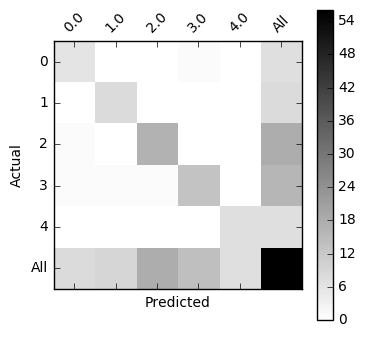

In [114]:
print(Y_test.shape)
print('           '+ label_to_emoji(0)+ '    ' + label_to_emoji(1) + '    ' +  label_to_emoji(2)+ '    ' + label_to_emoji(3)+'   ' + label_to_emoji(4))
print(pd.crosstab(Y_test, pred_test.reshape(56,), rownames=['Actual'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(Y_test, pred_test)

## Using LSTMS in Keras

In [115]:
import numpy as np
np.random.seed(0)
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
np.random.seed(1)

Using TensorFlow backend.


### Keras Minibatch

The common solution is padding because we can vectorize over the entire training set if all of them have the 
same sentence length ,so that the no. of blocks required in each LSTM layer will be same.

### The Embedding Layer

This layer converts every word in the sentence to its word embeddings which will acts as an input to the network.So in keras it is done by embedding layer.

In [118]:
#converts each sentence to its corresponding indices equivalent which can be given as an input to the 
#embedding layer
def sentences_to_index(X,word_to_index,maxlen):
    m=X.shape[0]
    X_indices=np.zeros((m,maxlen))
    for i in range(m):
        sent_words=X[i].lower().split()
        j=0
        for w in sent_words:
            X_indices[i,j]=word_to_index[w]
            j+=1
    return X_indices

In [123]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    emb_dim=word_to_vec_map["cucumber"].shape[0]
    vocab_length=len(word_to_vec_map)+1
    emb_matrix=np.zeros((vocab_length,emb_dim))
    words=word_to_vec_map.keys()
    for w in words:
        idx=word_to_index[w]
        emb_matrix[idx,:]=word_to_vec_map[w]
    embedding_layer=Embedding(input_dim=vocab_length,output_dim=emb_dim,trainable=False)#trainable is set to False cause during optimization it will not be trained further
    embedding_layer.build((None,))
    embedding_layer.set_weights([emb_matrix])
    return embedding_layer

In [126]:
embedding_layer = pretrained_embedding_layer(words_to_vec_map, words_to_index)

In [142]:
def emojify_v2(input_shape,word_to_vec_map,word_to_index):
    sentence_indices=Input(input_shape)
    embedding_layer=pretrained_embedding_layer(word_to_vec_map, word_to_index)
    embeddings=embedding_layer(sentence_indices)
    X=LSTM(units=128,return_sequences=True)(embeddings)
    X=Dropout(0.5)(X)
    X=LSTM(units=128)(X)
    X=Dropout(0.5)(X)
    X=Dense(units=5)(X)
    X=Activation('softmax')(X)
    model=Model(input=sentence_indices,output=X)
    return model

In [143]:
model=emojify_v2((maxlen,),words_to_vec_map,words_to_index)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 10)                0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 10, 50)            20000050  
_________________________________________________________________
lstm_4 (LSTM)                (None, 10, 128)           91648     
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 128)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
__________

/home/ajita/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("ac..., inputs=Tensor("in...)`


In [144]:
model.compile(loss="categorical_crossentropy",optimizer='adam',metrics=['accuracy'])

In [145]:
X_train_indices = sentences_to_index(X_train, words_to_index, maxlen)
Y_train_oh = convert_to_one_hot(Y_train, C = 5)

In [146]:
model.fit(X_train_indices,Y_train_oh,epochs=50,batch_size=32,shuffle=True)

Epoch 1/50
132/132 [==============================] - 2s 18ms/step - loss: 1.6041 - acc: 0.2045
Epoch 2/50
132/132 [==============================] - 0s 1ms/step - loss: 1.5244 - acc: 0.3485
Epoch 3/50
132/132 [==============================] - 0s 1ms/step - loss: 1.4970 - acc: 0.3561
Epoch 4/50
132/132 [==============================] - 0s 1ms/step - loss: 1.4458 - acc: 0.4394
Epoch 5/50
132/132 [==============================] - 0s 1ms/step - loss: 1.3681 - acc: 0.4091
Epoch 6/50
132/132 [==============================] - 0s 1ms/step - loss: 1.2994 - acc: 0.5303
Epoch 7/50
132/132 [==============================] - 0s 1ms/step - loss: 1.1139 - acc: 0.6136
Epoch 8/50
132/132 [==============================] - 0s 1ms/step - loss: 1.0091 - acc: 0.6742
Epoch 9/50
132/132 [==============================] - 0s 1ms/step - loss: 0.9229 - acc: 0.6667
Epoch 10/50
132/132 [==============================] - 0s 1ms/step - loss: 0.8209 - acc: 0.7121
Epoch 11/50
132/132 [===========================

In [149]:
X_test_indices = sentences_to_index(X_test, words_to_index, maxlen = maxlen)
Y_test_oh = convert_to_one_hot(Y_test, C = 5)
loss,acc=model.evaluate(X_test_indices,Y_test_oh)
print()
print("Test accuracy:{0}".format(acc))

56/56 [==============================] - 0s 4ms/step

Test accuracy:0.8214285714285714


In [153]:
#to visualize the incorect labelled examples
pred=model.predict(X_test_indices)
for i in range(X_test_indices.shape[0]):
    idx=np.argmax(pred[i])
    if (idx!=Y_test[i]):
        print("Expected emoji {0} prediction: {1} {2}".format(label_to_emoji(Y_test[i]),X_test[i],
                                                              label_to_emoji(idx)))

Expected emoji :smile: prediction: he got a very nice raise	 ❤️
Expected emoji :smile: prediction: she got me a nice present	 ❤️
Expected emoji :disappointed: prediction: work is hard	 :smile:
Expected emoji :disappointed: prediction: This girl is messing with me	 ❤️
Expected emoji :disappointed: prediction: work is horrible	 :smile:
Expected emoji 🍴 prediction: any suggestions for dinner	 :smile:
Expected emoji :disappointed: prediction: she is a bully	 ❤️
Expected emoji ❤️ prediction: I love you to the stars and back	 :smile:
Expected emoji :disappointed: prediction: go away	 ⚾
Expected emoji :disappointed: prediction: yesterday we lost again	 ⚾
